CREDIT CARD FAULT PREDICTION

IMPORTING PACKAGES

In [2]:
import numpy as np
import pandas as pd
seed = 69 # Set the random seed for the entire document

# Linear Models, their CV and Statsmods
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV, ElasticNet, ElasticNetCV
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy



# Classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC, SVC

# Classifier Metrics 
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, log_loss
from sklearn.metrics import auc, roc_curve, roc_auc_score, precision_recall_curve
from sklearn.metrics import fbeta_score, cohen_kappa_score

# Pre-processing packages
from sklearn.preprocessing import StandardScaler


# CV, Gridsearch, train_test_split, model selection packages
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV
from sklearn.model_selection import train_test_split


import time
import pickle

# Graph-Plotting packages
import seaborn as sns
import matplotlib.pyplot as plt
# plt.style.use('ggplot')  # nice plots
# sns.set_style('white')
# sns.set_style('whitegrid')
sns.set_style("whitegrid", {'axes.grid' : False})  # So that your grids have no axis

%matplotlib inline

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


READ DATASET

In [6]:

# This dataset contains information on default payments, demographic factors, credit data, history of payment, and
# bill statements of credit card clients in Taiwan from April 2005 to September 2005.

df = pd.read_csv('sample_data/UCI_Credit_Card.csv',sep=',')
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24,2,2,-1,-1,-2,-2,3913.0,3102.0,689.0,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,0,2,2682.0,1725.0,2682.0,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,0,0,29239.0,14027.0,13559.0,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,0,0,46990.0,48233.0,49291.0,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,0,0,8617.0,5670.0,35835.0,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ID                          30000 non-null  int64  
 1   LIMIT_BAL                   30000 non-null  float64
 2   SEX                         30000 non-null  int64  
 3   EDUCATION                   30000 non-null  int64  
 4   MARRIAGE                    30000 non-null  int64  
 5   AGE                         30000 non-null  int64  
 6   PAY_0                       30000 non-null  int64  
 7   PAY_2                       30000 non-null  int64  
 8   PAY_3                       30000 non-null  int64  
 9   PAY_4                       30000 non-null  int64  
 10  PAY_5                       30000 non-null  int64  
 11  PAY_6                       30000 non-null  int64  
 12  BILL_AMT1                   30000 non-null  float64
 13  BILL_AMT2                   300

In [8]:
# Renaming Columns into more understandable terms using rename function

# SEX changed to GENDER
# PAY_0 changed to PAY_1
# default.payment.next.month is too long and changed to something simplier, DEFAULT
df.rename(columns={'SEX':'GENDER',
                   'PAY_0':'PAY_1',
                   'default.payment.next.month':'DEFAULT',} , inplace=True)

df.drop('ID', axis=1, inplace=True) # Drop column ID

df.info()  # we see that we have 30,000 observations and no null values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 24 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   LIMIT_BAL  30000 non-null  float64
 1   GENDER     30000 non-null  int64  
 2   EDUCATION  30000 non-null  int64  
 3   MARRIAGE   30000 non-null  int64  
 4   AGE        30000 non-null  int64  
 5   PAY_1      30000 non-null  int64  
 6   PAY_2      30000 non-null  int64  
 7   PAY_3      30000 non-null  int64  
 8   PAY_4      30000 non-null  int64  
 9   PAY_5      30000 non-null  int64  
 10  PAY_6      30000 non-null  int64  
 11  BILL_AMT1  30000 non-null  float64
 12  BILL_AMT2  30000 non-null  float64
 13  BILL_AMT3  30000 non-null  float64
 14  BILL_AMT4  30000 non-null  float64
 15  BILL_AMT5  30000 non-null  float64
 16  BILL_AMT6  30000 non-null  float64
 17  PAY_AMT1   30000 non-null  float64
 18  PAY_AMT2   30000 non-null  float64
 19  PAY_AMT3   30000 non-null  float64
 20  PAY_AM

Variable Breakdown

DEFAULT: Default payment next month (1 = yes, 0 = no)

LIMIT_BAL: Amount of the given credit (NT dollar): it includes both the individual consumer credit and his/her family (supplementary) credit.

GENDER: Gender 

(1 = male; 2 = female).

EDUCATION: Education (1 = graduate school; 

2 = university; 

3 = high school; 

4 = others).

MARRIAGE: Marital status 

(1 = married; 

2 = single; 

3 = others).

AGE: Age (year).

PAY_1 ~ PAY_6: History of past payment.

We tracked the past monthly payment records (from April to September, 2005) as follows:

PAY_1 = the repayment status in September, 2005

PAY_2 = the repayment status in August, 2005;

. . .;

PAY_6 = the repayment status in April, 2005.

The measurement scale for the repayment status is:

-2 = no consumption;

-1 = pay duly;

1 = payment delay for one month;

2 = payment delay for two months;

. . .;

8 = payment delay for eight months;

9 = payment delay for nine months and above.

BILL_AMT1 ~ BILL_AMT6: Amount of bill statement (NT dollar).

BILL_AMT1 = amount of bill statement in September, 2005;

BILL_AMT2 = amount of bill statement in August, 2005;

. . .;

BILL_AMT6 = amount of bill statement in April, 2005.

PAY_AMT1 ~ PAY_AMT6: Amount of payment for previous month (NT dollar).

PAY_AMT1 = amount paid in September, 2005;

PAY_AMT2 = amount paid in August, 2005;

. . .;

PAY_AMT6 = amount paid in April, 2005.

In [9]:
#inspect the data
df.describe().T

,count,mean,std,min,25%,50%,75%,max
LIMIT_BAL,30000.0,167484.322667,129747.661567,10000.0,50000.00,140000.0,240000.00,1000000.0
GENDER,30000.0,1.603733,0.489129,1.0,1.00,2.0,2.00,2.0
EDUCATION,30000.0,1.853133,0.790349,0.0,1.00,2.0,2.00,6.0
MARRIAGE,30000.0,1.551867,0.521970,0.0,1.00,2.0,2.00,3.0
AGE,30000.0,35.485500,9.217904,21.0,28.00,34.0,41.00,79.0
PAY_1,30000.0,-0.016700,1.123802,-2.0,-1.00,0.0,0.00,8.0
PAY_2,30000.0,-0.133767,1.197186,-2.0,-1.00,0.0,0.00,8.0
PAY_3,30000.0,-0.166200,1.196868,-2.0,-1.00,0.0,0.00,8.0
PAY_4,30000.0,-0.220667,1.169139,-2.0,-1.00,0.0,0.00,8.0
PAY_5,30000.0,-0.266200,1.133187,-2.0,-1.00,0.0,0.00,8.0


DATA CLEANING

In [10]:
# We see from the above that there is data that needs to be cleaned. I.e. Education column.
print('Education Column Values: ', df['EDUCATION'].unique())

Education Column Values:  [2 1 3 5 4 6 0]


In [11]:
# You might speed up the exploration by just looking at a bar plot
# fig, ax = plt.subplots()
# sns.countplot(data=df,x='EDUCATION', order = df['EDUCATION'].value_counts().index, color='salmon')

# There exists values 0, 5 and 6 in this column.
# Since these are unknown (undefined), they can be grouped into the category 4: "Others"

df['EDUCATION'] = df['EDUCATION'].apply(lambda edu_value: edu_value 
                                        if ((edu_value > 0 and edu_value < 4)) 
                                        else 4) 
# Changes every value of x not within (and inclusive of) 1 ~ 3 to 4  

# Corrected changes
df['EDUCATION'].unique()

array([2, 1, 3, 4])

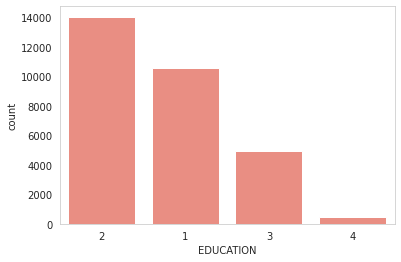

In [13]:
#plot and check for yourself

fig, ax = plt.subplots()
sns.countplot(data=df,x='EDUCATION', order = df['EDUCATION'].value_counts().index, color='salmon');
# df['EDUCATION'].value_counts().plot(kind='bar', );

MARRAIGE DATA CLEANING

In [15]:
# We see from .describe() that there are some discrepancies in the marriage column
print("Marriage Column Values: ", df['MARRIAGE'].unique())

# fig, ax = plt.subplots()
# sns.countplot(data=df, x='MARRIAGE', order = df['MARRIAGE'].value_counts().index, color='salmon')

# There exists 0 in this column
# Since this is unknown (undefined), similar to education, they can be grouped into 3: "Others"

df['MARRIAGE'] = df['MARRIAGE'].apply(lambda marriage_value: marriage_value
                                     if (marriage_value > 0 and marriage_value < 3)
                                     else 3) # changes every value of x not within (and inclusive of) 1 and 2 to 3

# Corrected changes
df['MARRIAGE'].unique()

Marriage Column Values:  [1 2 3]


array([1, 2, 3])

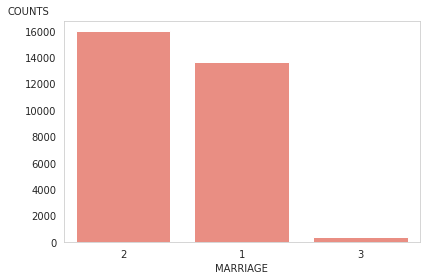

In [16]:
#plot and see

fig, ax = plt.subplots()
sns.countplot(data=df, x='MARRIAGE', order = df['MARRIAGE'].value_counts().index, color='salmon')
ax.set_ylabel('COUNTS', rotation=0, labelpad=40)
ax.yaxis.set_label_coords(-0.1,1.02)

plt.tight_layout()
plt.show();

DATA EXPLORATION

MAPPING THE TARGET

In [17]:
print(df['DEFAULT'].value_counts(),'\n')
print(len(df['DEFAULT']))

0    23364
1     6636
Name: DEFAULT, dtype: int64 

30000


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


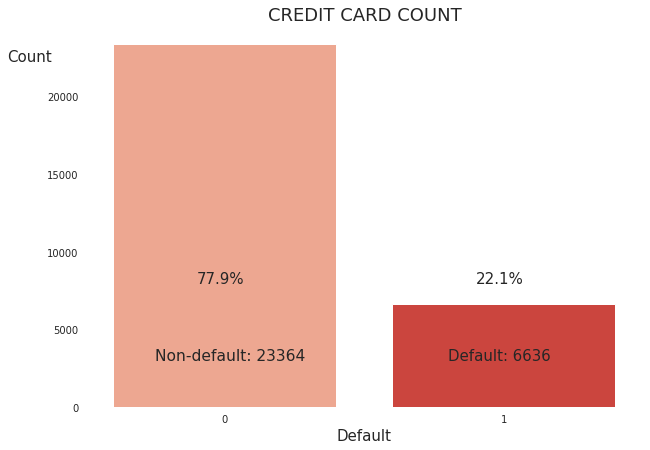

In [18]:
# Frequency of the defaults
default = df['DEFAULT'].sum() # adds up all the default cases in the df
no_default = len(df['DEFAULT']) - default  # entire dataset - default cases

# Percentage of the defaults
default_perc = round(default/len(df['DEFAULT']) * 100, 1)
no_default_perc = round(no_default/len(df['DEFAULT']) * 100, 1)

# Plotting Target
fig, ax = plt.subplots(figsize=(10,7))  # Sets size of graph
sns.set_context('notebook', font_scale=1.2)  # Affects things like size of label, lines and other elements of the plot.

sns.countplot('DEFAULT',data=df, palette="Reds")   
plt.annotate('Non-default: {}'.format(no_default), 
             xy=(-0.25, 3000), # xy = (x dist from 0, y dist from 0)
            size=15.5)

plt.annotate('Default: {}'.format(default), 
             xy=(0.8, 3000), # xy = (x dist from 0, y dist from 0)
            size=15)
plt.annotate('{}%'.format(no_default_perc), xy=(-0.1, 8000),size=15)
plt.annotate('{}%'.format(default_perc), xy=(0.9, 8000),size=15)
plt.title('CREDIT CARD COUNT', size=18)
plt.xlabel("Default",size=15)
plt.ylabel('Count', rotation=0, 
           labelpad=40, # Adjusts distance of the title from the graph
           size=15)
ax.yaxis.set_label_coords(-0.1,.9)

plt.box(False)        # Removes the bounding area
plt.savefig('target_skew.png', transparent = True)

Frequency of explanatory variables by Defaulted / Non-Defaulted cards

Categorical explanatory variables
Variable Breakdown
LIMIT_BAL: Amount of the given credit (NT dollar): it includes both the individual consumer credit and his/her family (supplementary) credit.


GENDER: Gender (1 = male; 2 = female).


EDUCATION: Education (1 = graduate school; 2 = university; 3 = high school; 4 = others).

MARRIAGE: Marital status (1 = married; 2 = single; 3 = others).

PAY_1 ~ PAY_6: History of past payment.
We tracked the past monthly payment records (from April to September, 2005) as follows:

PAY_1 = the repayment status in September, 2005


PAY_2 = the repayment status in August, 2005;

. . .;

PAY_6 = the repayment status in April, 2005.

In [19]:
# Creating a new dataframe with just the categorical explanatory variables
df_categorical = df[['GENDER', 'EDUCATION', 'MARRIAGE', 'PAY_1', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6'
                     ,'DEFAULT']]

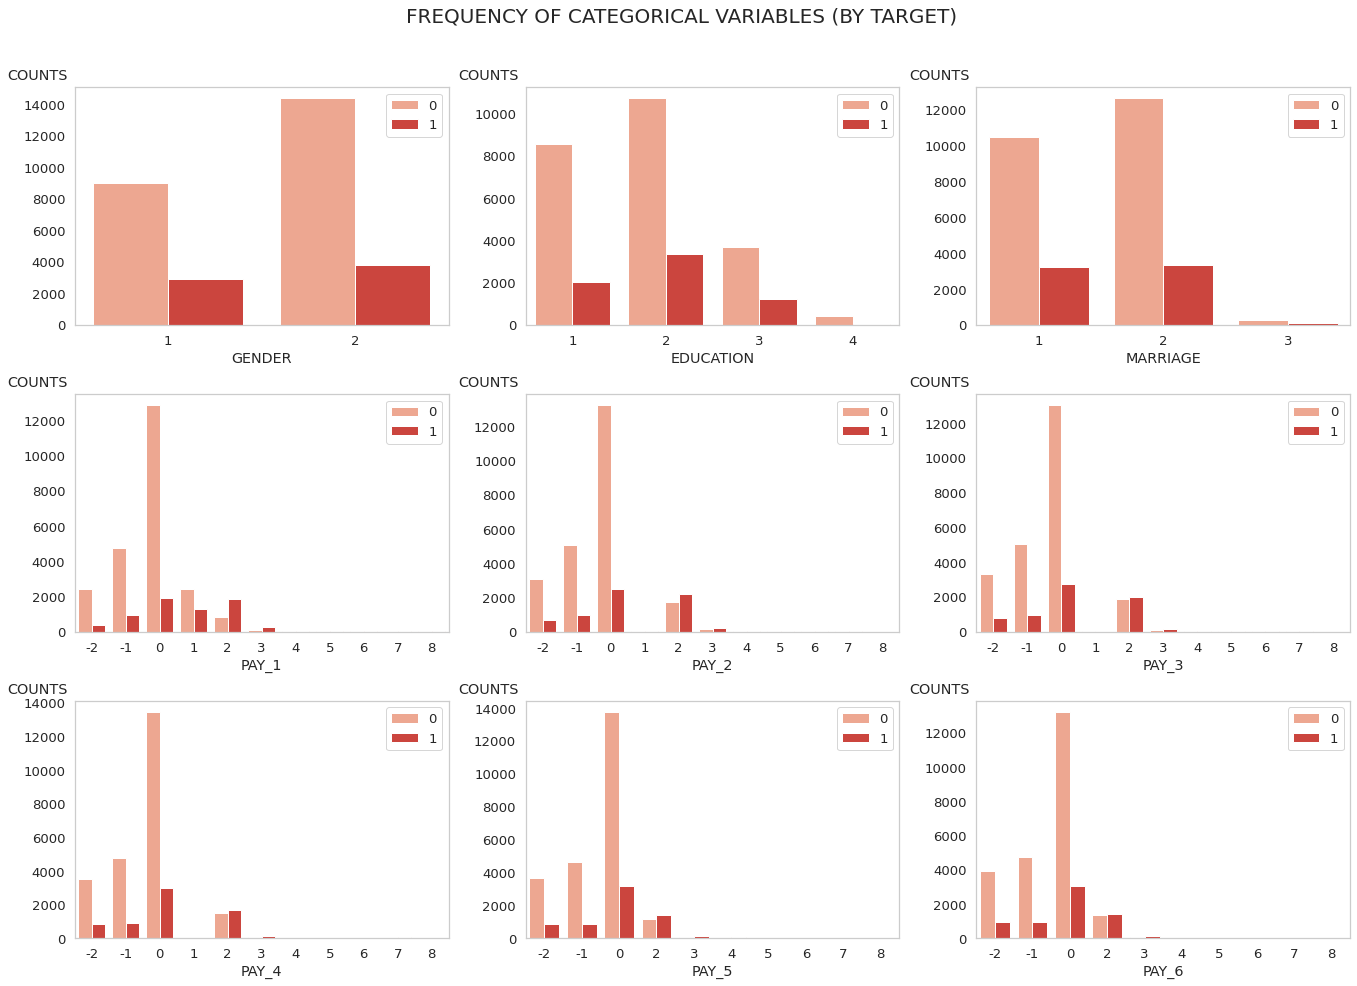

In [20]:
f, axes = plt.subplots(3, 3, figsize=(19,14), facecolor='white')
f.suptitle("FREQUENCY OF CATEGORICAL VARIABLES (BY TARGET)",size=20)

# Creating plots of each categorical variable to target 
ax1 = sns.countplot(x='GENDER', hue = 'DEFAULT', data=df_categorical, palette='Reds', ax=axes[0,0])
ax2 = sns.countplot(x='EDUCATION', hue = 'DEFAULT', data=df_categorical, palette='Reds', ax=axes[0,1])
ax3 = sns.countplot(x='MARRIAGE', hue = 'DEFAULT', data=df_categorical, palette='Reds', ax=axes[0,2])
ax4 = sns.countplot(x='PAY_1', hue = 'DEFAULT', data=df_categorical, palette='Reds', ax=axes[1,0])
ax5 = sns.countplot(x='PAY_2', hue = 'DEFAULT', data=df_categorical, palette='Reds', ax=axes[1,1])
ax6 = sns.countplot(x='PAY_3', hue = 'DEFAULT', data=df_categorical, palette='Reds', ax=axes[1,2])
ax7 = sns.countplot(x='PAY_4', hue = 'DEFAULT', data=df_categorical, palette='Reds', ax=axes[2,0])
ax8 = sns.countplot(x='PAY_5', hue = 'DEFAULT', data=df_categorical, palette='Reds', ax=axes[2,1])
ax9 = sns.countplot(x='PAY_6', hue = 'DEFAULT', data=df_categorical, palette='Reds', ax=axes[2,2])

# Setting legends to upper right
ax1.legend(loc="upper right")
ax2.legend(loc="upper right")
ax3.legend(loc="upper right")
ax4.legend(loc="upper right")
ax5.legend(loc="upper right")
ax6.legend(loc="upper right")
ax7.legend(loc="upper right")
ax8.legend(loc="upper right")
ax9.legend(loc="upper right")


# Changing ylabels to horizontal and changing their positions
ax1.set_ylabel('COUNTS', rotation=0, labelpad=40)  # Labelpad adjusts distance of the title from the graph
ax1.yaxis.set_label_coords(-0.1,1.02)              # (x, y)
ax2.set_ylabel('COUNTS', rotation=0, labelpad=40)
ax2.yaxis.set_label_coords(-0.1,1.02)
ax3.set_ylabel('COUNTS', rotation=0, labelpad=40)
ax3.yaxis.set_label_coords(-0.1,1.02)
ax4.set_ylabel('COUNTS', rotation=0, labelpad=40)
ax4.yaxis.set_label_coords(-0.1,1.02)
ax5.set_ylabel('COUNTS', rotation=0, labelpad=40)
ax5.yaxis.set_label_coords(-0.1,1.02)
ax6.set_ylabel('COUNTS', rotation=0, labelpad=40)
ax6.yaxis.set_label_coords(-0.1,1.02)
ax7.set_ylabel('COUNTS', rotation=0, labelpad=40)
ax7.yaxis.set_label_coords(-0.1,1.02)
ax8.set_ylabel('COUNTS', rotation=0, labelpad=40)
ax8.yaxis.set_label_coords(-0.1,1.02)
ax9.set_ylabel('COUNTS', rotation=0, labelpad=40)
ax9.yaxis.set_label_coords(-0.1,1.02)

# Shifting the Super Title higher
f.tight_layout()  # Prevents graphs from overlapping with each other
f.subplots_adjust(top=0.9);

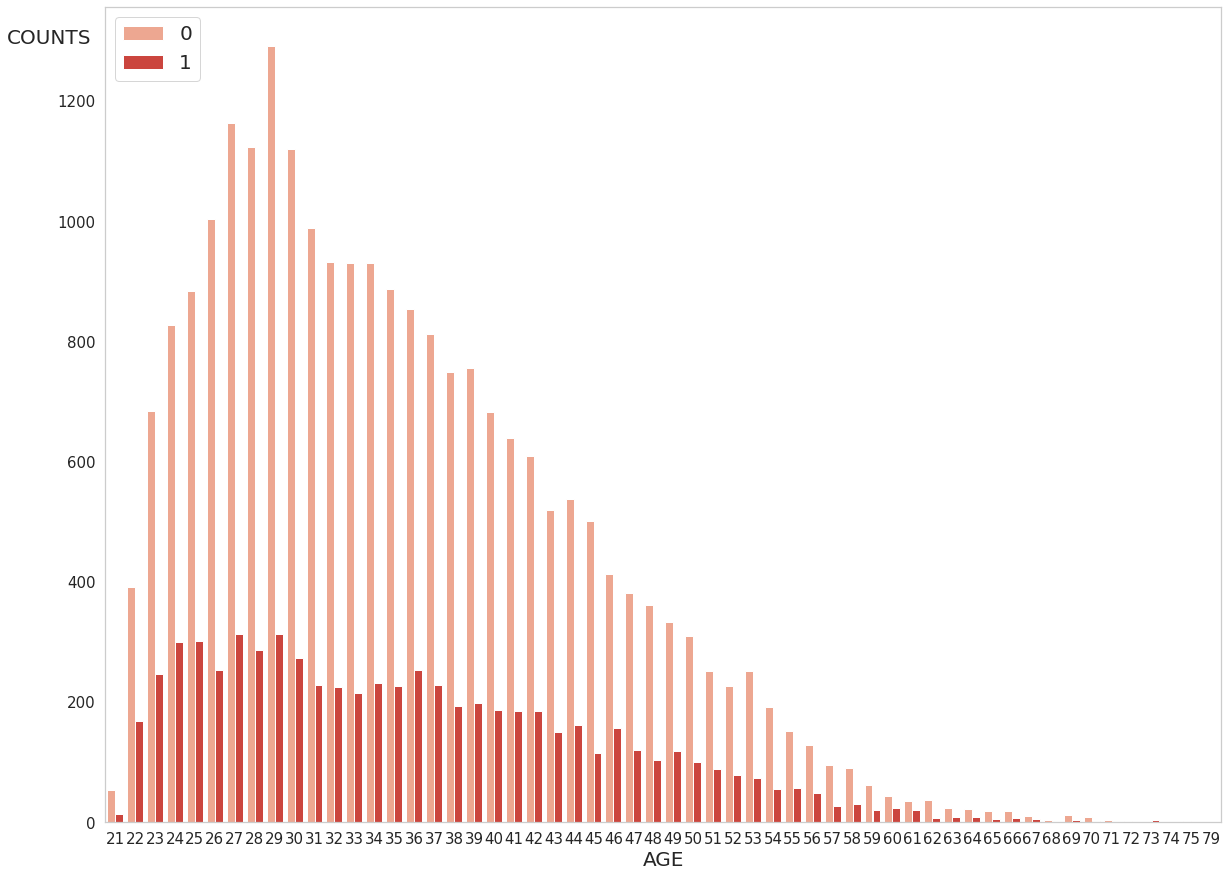

In [21]:
# By Age
fig, axz = plt.subplots(figsize=(20,15))

axz = sns.countplot(x='AGE', hue='DEFAULT', data=df, palette='Reds')


axz.set_ylabel('COUNTS', rotation=0, labelpad=40,size=20)
axz.set_xlabel('AGE', size=20)
axz.yaxis.set_label_coords(-0.05, 0.95)  # (x, y)
axz.legend(loc=0,fontsize=20);

axz.tick_params(labelsize=15)  # Changes size of the values on the label

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  This is separate from the ipykernel package so we can avoid doing imports until


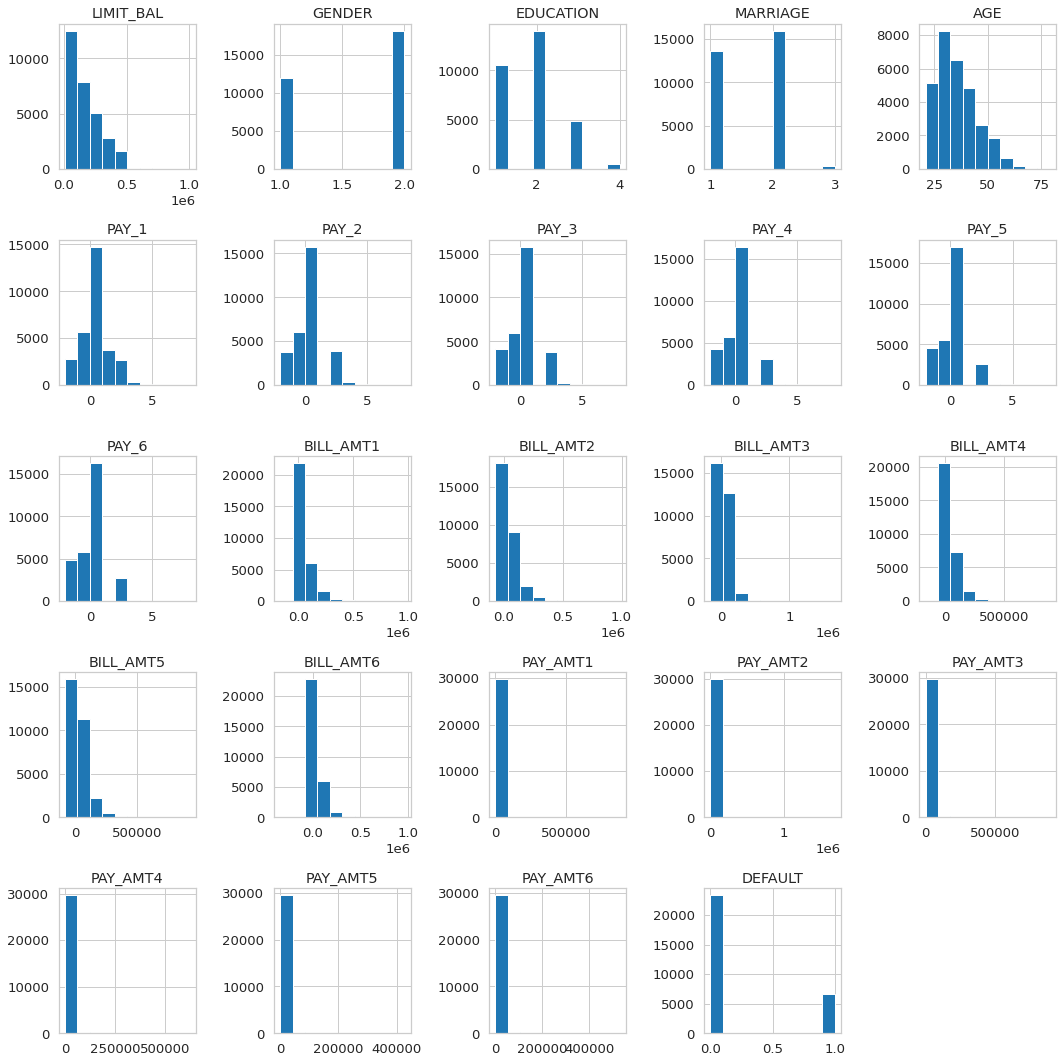

In [22]:
# Freq distribution of all data
fig, ax = plt.subplots(figsize=(15,15))
pd.DataFrame.hist(df,ax=ax)
plt.tight_layout();

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


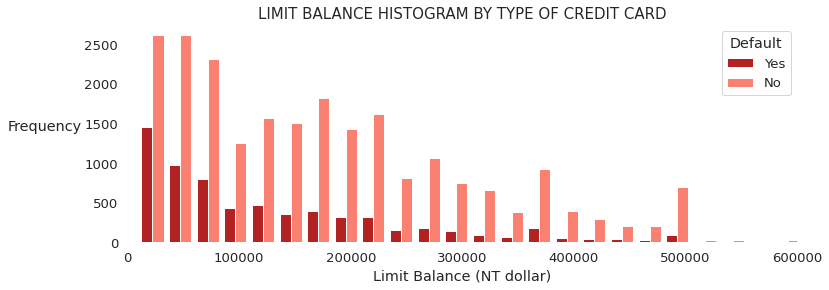

In [23]:
#columns for lIMIT_BALANCE?
x1 = list(df[df['DEFAULT'] == 1]['LIMIT_BAL'])
x2 = list(df[df['DEFAULT'] == 0]['LIMIT_BAL'])

fig2, ax_lim_bal = plt.subplots(figsize=(12,4))
sns.set_context('notebook', font_scale=1.2)
#sns.set_color_codes("pastel")
plt.hist([x1, x2], bins = 40, color=['firebrick', 'salmon'])
plt.xlim([0,600000])
plt.legend(['Yes', 'No'], title = 'Default', loc='upper right', facecolor='white')
plt.xlabel('Limit Balance (NT dollar)')
plt.ylabel('Frequency', rotation=0,labelpad=40)
plt.title('LIMIT BALANCE HISTOGRAM BY TYPE OF CREDIT CARD', SIZE=15)
plt.box(False)
plt.savefig('ImageName', format='png', dpi=200, transparent=True);

FEATURE SELECTION

CORRELATION MATRIX

In [24]:
df.columns

Index(['LIMIT_BAL', 'GENDER', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_1', 'PAY_2',
       'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'DEFAULT'],
      dtype='object')

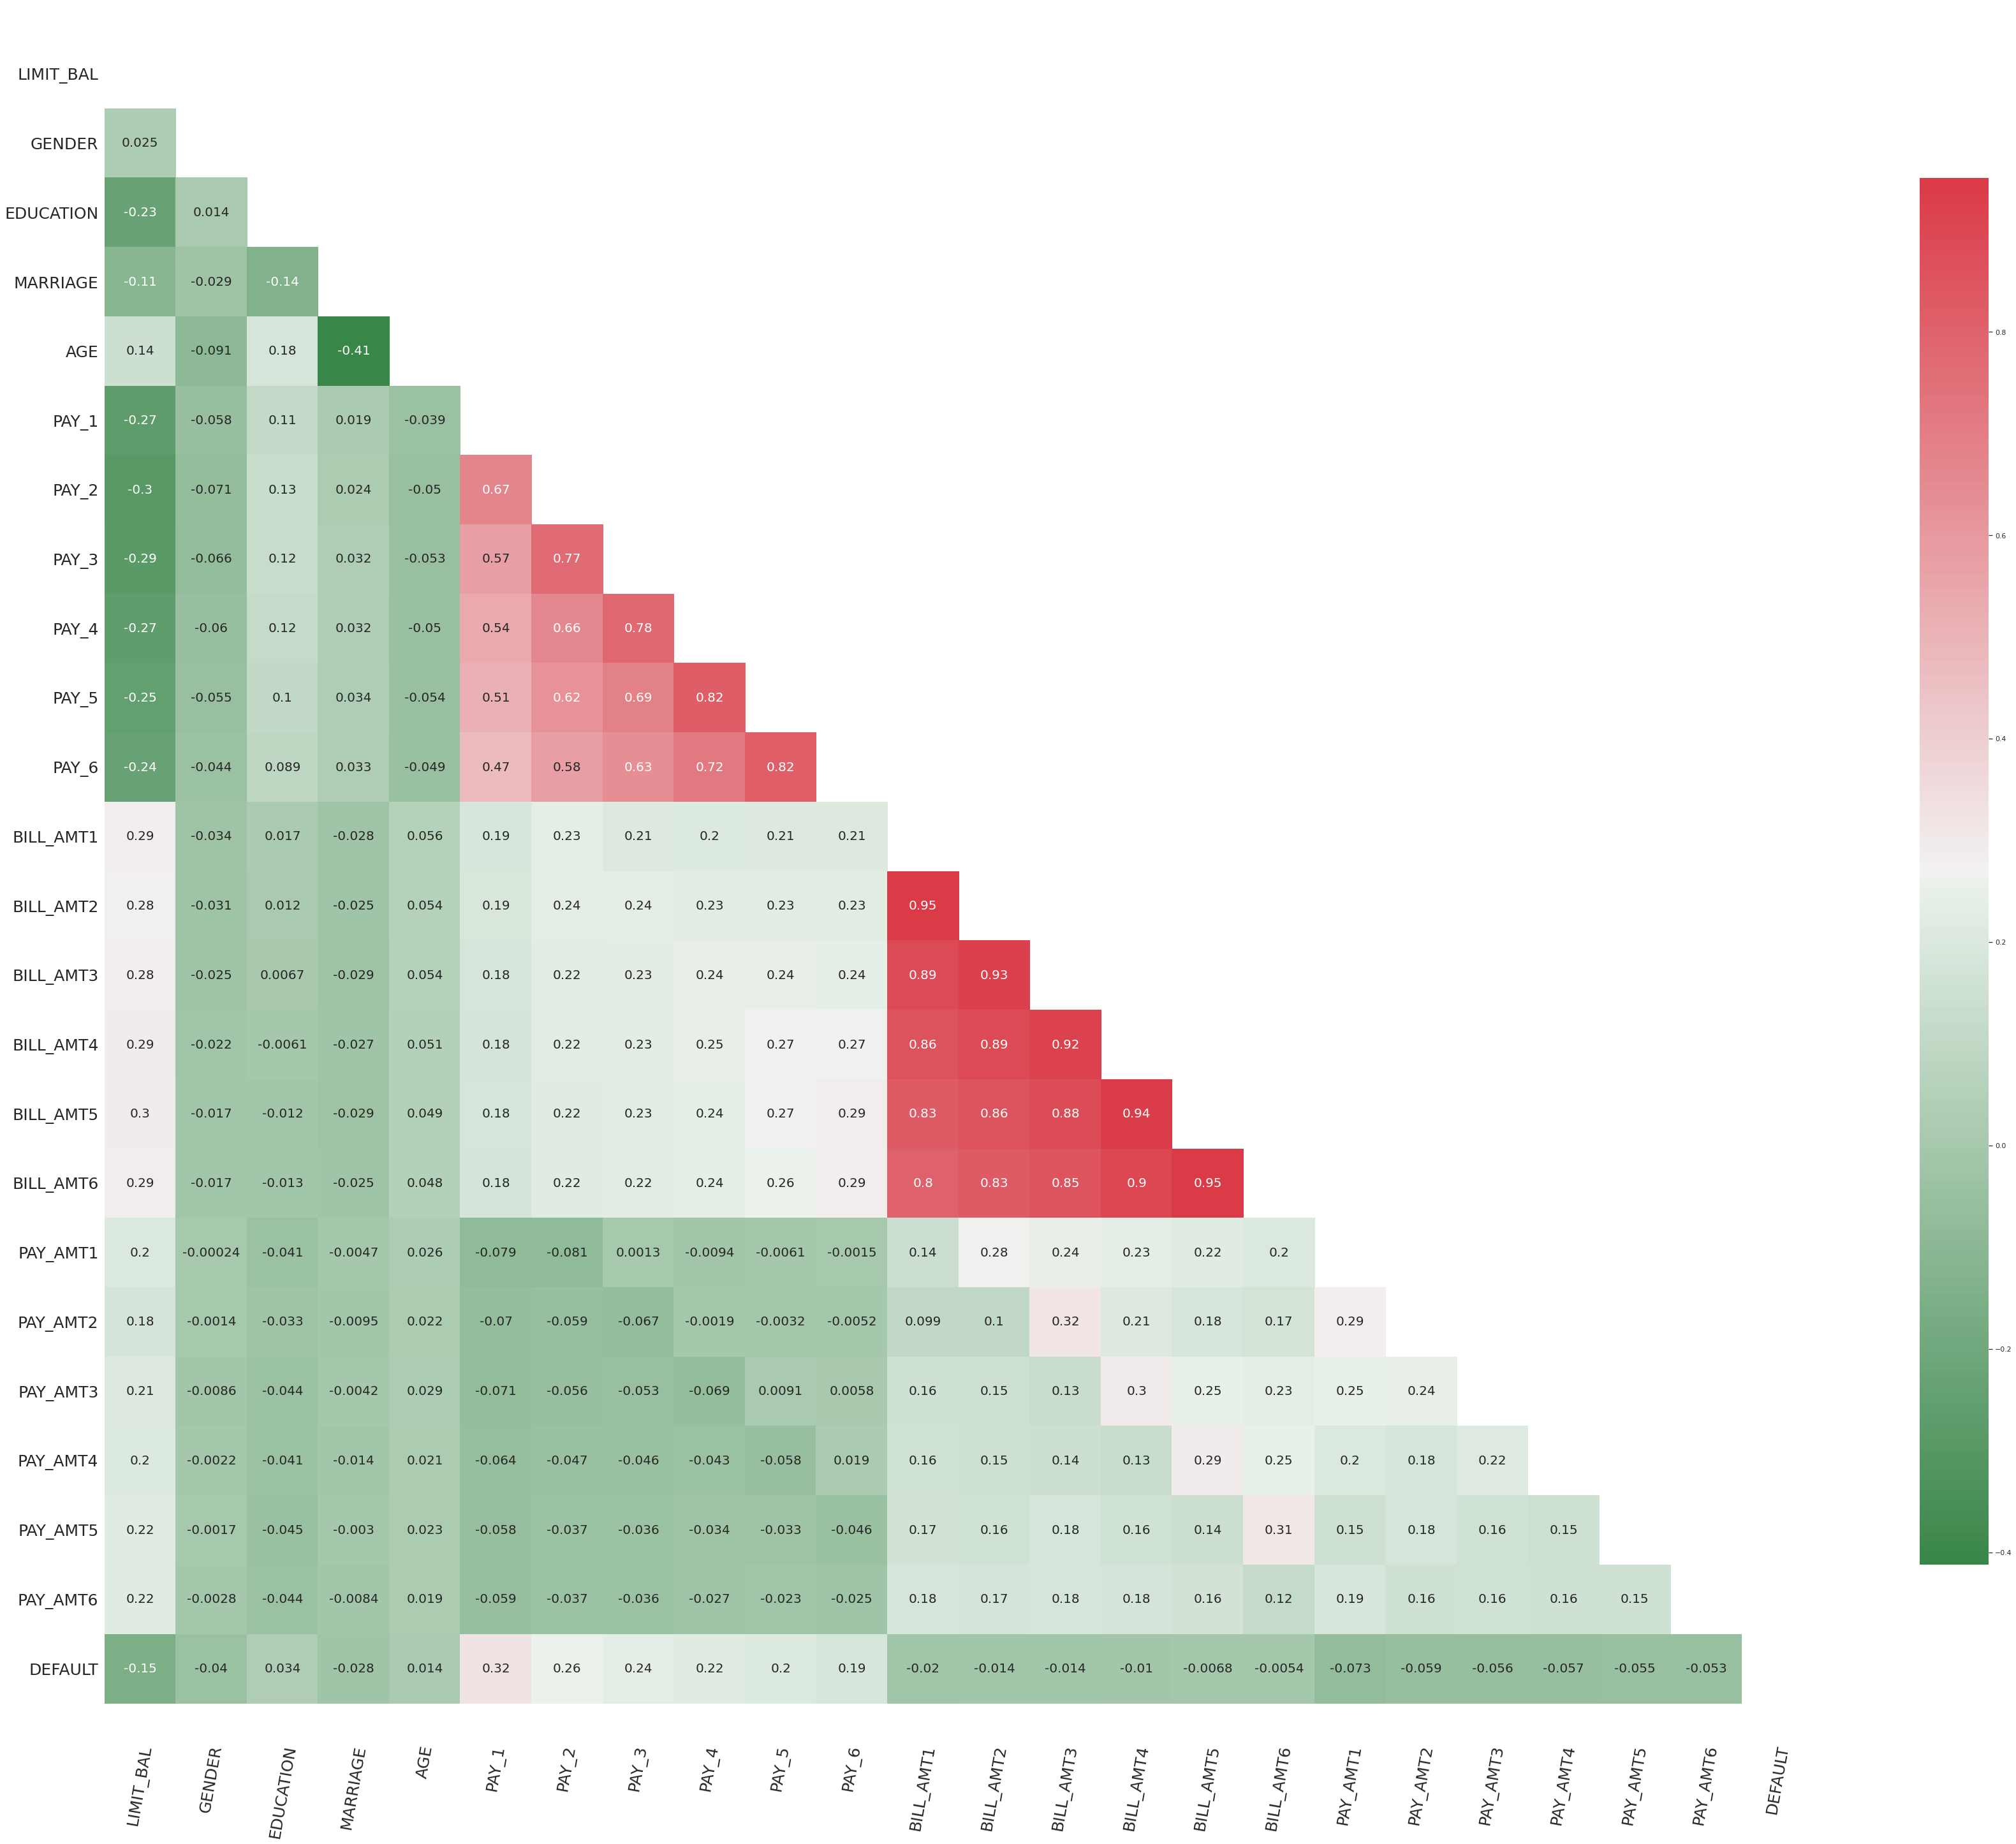

In [25]:
# Now that we have our features, let's plot them on a correlation matrix to remove anything that might 
# cause multi-colinearity within our model

sns.set(style="white")
# Creating the data
data = df.corr()


# Generate a mask for the upper triangle
mask = np.zeros_like(data, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True


# Set up the matplotlib figure to control size of heatmap
fig, ax = plt.subplots(figsize=(60,50))


# Create a custom color palette
cmap = \
sns.diverging_palette(133, 10,
                      as_cmap=True)  
# as_cmap returns a matplotlib colormap object rather than a list of colors
# Green = Good (low correlation), Red = Bad (high correlation) between the independent variables

# Plot the heatmap
g = sns.heatmap(data=data, annot=True, cmap=cmap, ax=ax, 
                mask=mask, # Splits heatmap into a triangle
                annot_kws={"size":20},  #Annotation size
               cbar_kws={"shrink": 0.8} # Color bar size
               );
# Prevent Heatmap Cut-Off Issue
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

# Changes size of the values on the label
ax.tick_params(labelsize=25) 

ax.set_yticklabels(g.get_yticklabels(), rotation=0);
ax.set_xticklabels(g.get_xticklabels(), rotation=80);

plt.savefig('correlation_heatmap.png', transparent = True)

In [26]:
df_default_corrs = data.iloc[:-1,-1:]   # data = df.corr()  REMEMBER!! HAHAHAHAHAHA
df_default_corrs

,DEFAULT
LIMIT_BAL,-0.153520
GENDER,-0.039961
EDUCATION,0.033842
MARRIAGE,-0.027575
AGE,0.013890
PAY_1,0.324794
PAY_2,0.263551
PAY_3,0.235253
PAY_4,0.216614
PAY_5,0.204149


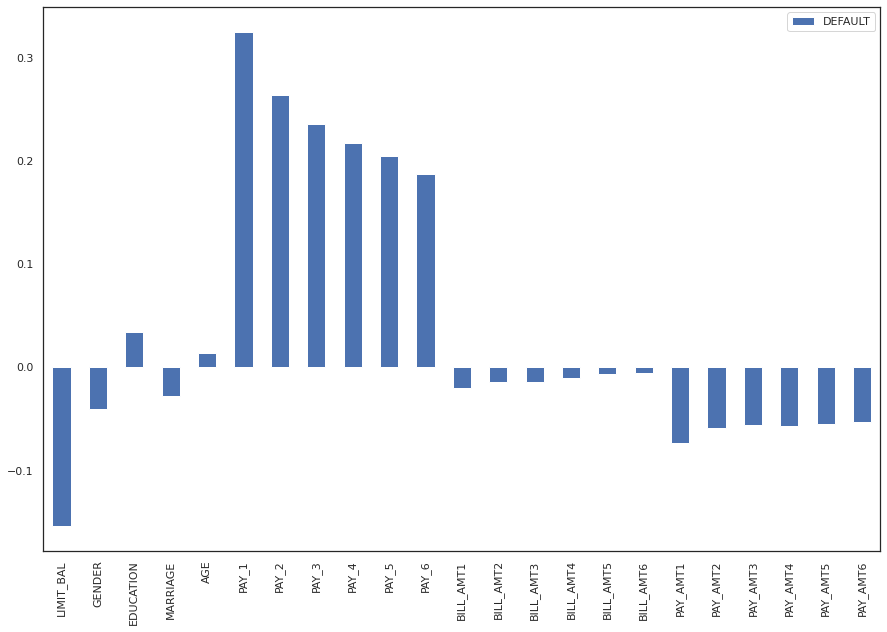

In [27]:
df_default_corrs.plot(kind='bar',figsize=(15,10))

In [28]:
data.iloc[:-1,-1:].max()  # This refers to PAY_1

DEFAULT    0.324794
dtype: float64

Feature Importance Described by RandomForest

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


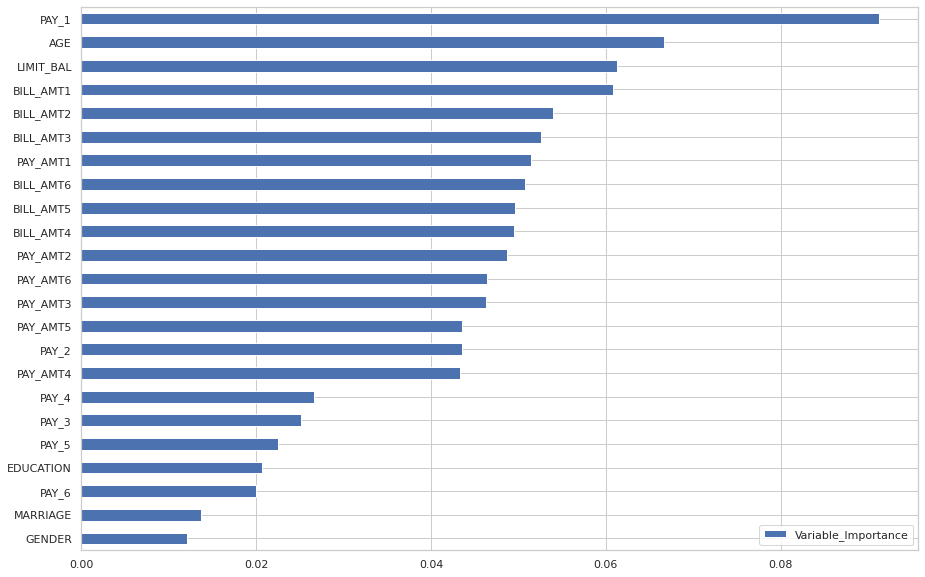

In [29]:
# Separate data into X and Y components
X = df.iloc[:,:-1]  
y = df.iloc[:,-1:]

# Data splitting for 80% Train/Val and 20% Test 
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size = 0.2, random_state=69) # 20% holdout 
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size = 0.25, random_state=69) # Train/Val

# Initializing the scaler  (Just scale every single time lol)
from sklearn.preprocessing import StandardScaler
std = StandardScaler()
std.fit(X_train_val.values)

## Scale the Predictors on the train/val dataset
X_train_val_scaled = std.transform(X_train_val.values) 

## This line instantiates the model. 
rf = RandomForestClassifier() 

## Fit the model on your training data.
rf.fit(X_train_val_scaled, y_train_val) 

# Obtain the feature importance
feature_importance = pd.DataFrame(rf.feature_importances_,
                                   index = X_train.columns,
                                   columns=['Variable_Importance']).sort_values('Variable_Importance',ascending=True)

# Set seaborn contexts 
sns.set(style="whitegrid")

feature_importance.plot.barh(figsize=(15,10))

In [30]:
# import pickle

# with open('dataset_raw_virgin.pickle', 'wb') as to_write:
#     pickle.dump(df, to_write)

# Opening new pickled dataframe
with open('my_dataframe.pickle','rb') as read_file:
    new_df = pickle.load(read_file)
    
new_df.head(5)


FileNotFoundError: ignored

Preliminary Model 

Test with Virgin Dataset

The models I have selected to use are:

Logistic Regression

K-Nearest Neighbor

Naive Bayes Classifier

Support Vector Machines (LinearSVC)

Decision Trees

Random Forest

Ensemble (MAYBE)

Scoring Metrics:

ROC/AUC

Precision/Recall

F1

LLCE (Cross Entropy)

Training, Validating and Scoring all Models (No Scaling)

In [31]:
## Baseline model performance evaluation

# to give model baseline report with cross-validation in dataframe 
def baseline_report_cv_(model, X, y, n_splits, name):
    """
    Accepts a model object, X (independent variables), y (target), n_splits and name of the model
    and returns a model with various scoring metrics of each classifier model on a cross-validation split
    ----
    Input: model object, X, y, n_splits (integer), name (str)
    Output: Various metric scores of a model.
    """
    # Splitting the data into 80% training/validation data and 20% testing data
    X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=69)
#     # Splitting the training data into 60% training data and 20% validation data.
#     X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=69)
     
    # Creating a shuffled kfold of 5
    cv = KFold(n_splits=n_splits, shuffle=True, random_state=1000) 
    accuracy     = np.mean(cross_val_score(model, X_train_val, y_train_val,cv=cv, scoring='accuracy'))
    precision    = np.mean(cross_val_score(model, X_train_val, y_train_val,cv=cv, scoring='precision'))
    recall       = np.mean(cross_val_score(model, X_train_val, y_train_val,cv=cv, scoring='recall'))
    f1score      = np.mean(cross_val_score(model, X_train_val, y_train_val,cv=cv, scoring='f1'))
    rocauc       = np.mean(cross_val_score(model, X_train_val, y_train_val,cv=cv, scoring='roc_auc'))
    df_model = pd.DataFrame({'model'        : [name],
                             'accuracy'     : [accuracy],
                             'precision'    : [precision],
                             'recall'       : [recall],
                             'f1score'      : [f1score],
                             'rocauc'       : [rocauc],
                             'timetaken'    : [0]       })   # timetaken for comparison later
    return df_model


# to evaluate baseline models
gnb = GaussianNB()
logit = LogisticRegression()
knn = KNeighborsClassifier()
decisiontree = DecisionTreeClassifier()
randomforest = RandomForestClassifier()
linearsvc = LinearSVC()

# Scaling the inputs into model
# Separate data into X and Y components
X = df.iloc[:,:-1]  
y = df.iloc[:,-1:]
# to concat all models
df_models = pd.concat([baseline_report_cv_(gnb, X, y, 5, 'GaussianNB'),
                       baseline_report_cv_(logit, X, y, 5, 'LogisticRegression'),
                       baseline_report_cv_(knn, X, y, 5, 'KNN'),
                       baseline_report_cv_(decisiontree, X, y, 5, 'DecisionTree'),
                       baseline_report_cv_(randomforest, X, y, 5, 'RandomForest'),
                       baseline_report_cv_(linearsvc, X, y, 5, 'LinearSVC')
                       ], axis=0).reset_index()

df_models_no_scale = df_models.drop('index', axis=1)
df_models_no_scale

/usr/local/lib/python3.7/dist-packages/sklearn/naive_bayes.py:206: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/naive_bayes.py:206: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/naive_bayes.py:206: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/naive_bayes.py:206: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = col

,model,accuracy,precision,recall,f1score,rocauc,timetaken
0,GaussianNB,0.401875,0.251075,0.862974,0.388900,0.678405,0
1,LogisticRegression,0.779375,0.133333,0.000360,0.000719,0.653810,0
2,KNN,0.751625,0.371416,0.182394,0.244594,0.606955,0
3,DecisionTree,0.724792,0.378990,0.413845,0.393037,0.612918,0
4,RandomForest,0.815792,0.642493,0.362670,0.463749,0.761972,0
5,LinearSVC,0.666500,0.239109,0.025744,0.023236,0.524084,0


Training, Validating and Scoring all Models (Scaling)

In [33]:
## Scaled Dataset Model performance evaluation

# to evaluate baseline models
gnb = GaussianNB()
logit = LogisticRegression()
knn = KNeighborsClassifier()
decisiontree = DecisionTreeClassifier()
randomforest = RandomForestClassifier()
linearsvc = LinearSVC()

# Scaling the inputs into model
# Separate data into X and Y components
X = df.iloc[:,:-1]  
y = df.iloc[:,-1:]

## Scale data (just scale everything lol)
std = StandardScaler()
std.fit(X.values)

## Scale the Predictors
X = std.transform(X.values)


# to concat all models
df_models = pd.concat([baseline_report_cv_(gnb, X, y, 5, 'GaussianNB'),
                       baseline_report_cv_(logit, X, y, 5, 'LogisticRegression'),
                       baseline_report_cv_(knn, X, y, 5, 'KNN'),
                       baseline_report_cv_(decisiontree, X, y, 5, 'DecisionTree'),
                       baseline_report_cv_(randomforest, X, y, 5, 'RandomForest'),
                       baseline_report_cv_(linearsvc, X, y, 5, 'LinearSVC')
                       ], axis=0).reset_index()

df_models_scale = df_models.drop('index', axis=1)
df_models_scale

/usr/local/lib/python3.7/dist-packages/sklearn/naive_bayes.py:206: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/naive_bayes.py:206: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/naive_bayes.py:206: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/naive_bayes.py:206: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = col

,model,accuracy,precision,recall,f1score,rocauc,timetaken
0,GaussianNB,0.757458,0.461551,0.590200,0.517790,0.737272,0
1,LogisticRegression,0.809625,0.709866,0.233341,0.350930,0.720868,0
2,KNN,0.790542,0.540198,0.339816,0.417066,0.702370,0
3,DecisionTree,0.724833,0.384126,0.409707,0.397761,0.610350,0
4,RandomForest,0.813208,0.645015,0.361804,0.465367,0.760684,0
5,LinearSVC,0.801875,0.726459,0.163236,0.265479,0.717777,0


Training, Validating and Scoring all Models (OverSampling/UnderSampling), no Scaling

In [34]:
df['DEFAULT'].value_counts()

0    23364
1     6636
Name: DEFAULT, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


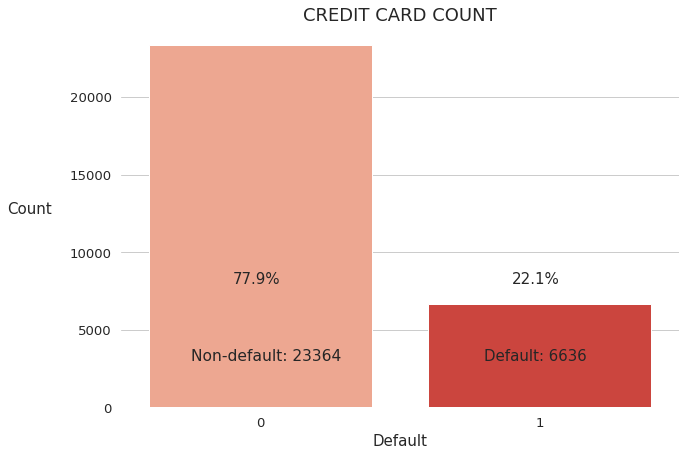

In [35]:
# Frequency of the defaults
default = df['DEFAULT'].sum() # adds up all the default cases in the df
no_default = len(df['DEFAULT']) - default  # entire dataset - default cases

# Percentage of the defaults
default_perc = round(default/len(df['DEFAULT']) * 100, 1)
no_default_perc = round(no_default/len(df['DEFAULT']) * 100, 1)

# Plotting Target
plt.figure(figsize=(10,7))  # Sets size of graph
sns.set_context('notebook', font_scale=1.2)  # Affects things like size of label, lines and other elements of the plot.

sns.countplot('DEFAULT',data=df, palette="Reds")   
plt.annotate('Non-default: {}'.format(no_default), 
             xy=(-0.25, 3000), # xy = (x dist from 0, y dist from 0)
            size=15.5)

plt.annotate('Default: {}'.format(default), 
             xy=(0.8, 3000), # xy = (x dist from 0, y dist from 0)
            size=15)
plt.annotate('{}%'.format(no_default_perc), xy=(-0.1, 8000),size=15)
plt.annotate('{}%'.format(default_perc), xy=(0.9, 8000),size=15)
plt.title('CREDIT CARD COUNT', size=18)
plt.xlabel("Default",size=15)
plt.ylabel('Count', rotation=0, 
           labelpad=40, # Adjusts distance of the title from the graph
           size=15)

plt.box(False)        # Removes the bounding area
plt.savefig('target_skew.png')

Brief Explanation:
We can see from this graph that there seems to be some class imbalance involved. 

Therefore, we can try doing some sampling in this case

Training, Validating and Scoring all Models (SMOTE, no scaling)

In [36]:
## SMOTE Dataset model performance evaluation

# Smote with no scaling with cross-validation in dataframe 
def baseline_report_cv_smote(model, X, y, n_splits, name):
    """
    Accepts a model object, X (independent variables), y (target), n_splits and name of the model, SMOTE's the data
    and returns a model with various scoring metrics of each classifier model on a cross-validation split
    ----
    Input: model object, X, y, n_splits (integer), name (str)
    Output: Various metric scores of a model.
    """
    from imblearn.over_sampling import SMOTE # Allows for smoting if you forget to initialize it before running func
    
    # Splitting the data into 80% training/validation data and 20% testing data
    X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=69)
    # Splitting the training data into 60% training data and 20% validation data.
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=69)
    
    
    #this helps with the way kf will generate indices below
    X_train_val, y_train_val = np.array(X_train_val), np.array(y_train_val)
    
    
    # Creating a shuffled kfold of 5
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=1000) 
    
    clf_model_acc_scores_cv = []
    clf_model_precision_scores_cv = []
    clf_model_recall_scores_cv = []
    clf_model_f1_scores_cv = []
    clf_model_rocauc_scores_cv = []

     # Manual Cross-Validation
    for train_ind, val_ind in kf.split(X_train_val, y_train_val):

        # Assigning train and validation values for an individual fold
        X_train, y_train = X_train_val[train_ind], y_train_val[train_ind]
        X_val, y_val = X_train_val[val_ind], y_train_val[val_ind] 

        # Creating the SMOTE data
        X_smoted, y_smoted = SMOTE(random_state=69).fit_sample(X_train, y_train)
        
        # Initializing model
        clf_model = model.fit(X_smoted, y_smoted) # Train model on SMOTE'd data
        y_pred = clf_model.predict(X_val)  # Y pred after testing on validation data split
        
        # Save scores of model
        clf_model_acc_score = accuracy_score(y_val, y_pred)
        clf_model_precision_score = precision_score(y_val, y_pred)
        clf_model_recall_score = recall_score(y_val, y_pred)
        clf_model_f1_score = f1_score(y_val, y_pred)   
        clf_model_rocauc_score = roc_auc_score(y_val, y_pred)
        
        # Append scores of model their scoring lists
        clf_model_acc_scores_cv.append(clf_model_acc_score)
        clf_model_precision_scores_cv.append(clf_model_precision_score)
        clf_model_recall_scores_cv.append(clf_model_recall_score)
        clf_model_f1_scores_cv.append(clf_model_f1_score)
        clf_model_rocauc_scores_cv.append(clf_model_rocauc_score)
        
        accuracy     = np.mean(clf_model_acc_scores_cv)
    precision    = np.mean(clf_model_precision_scores_cv)
    recall       = np.mean(clf_model_recall_scores_cv)
    f1score      = np.mean(clf_model_f1_scores_cv)
    rocauc       = np.mean(clf_model_rocauc_scores_cv)
    df_model = pd.DataFrame({'model'        : [name],
                             'accuracy'     : [accuracy],
                             'precision'    : [precision],
                             'recall'       : [recall],
                             'f1score'      : [f1score],
                             'rocauc'       : [rocauc],
                             'timetaken'    : [0]       })   # timetaken for comparison later
    return df_model


# to evaluate baseline models
gnb = GaussianNB()
logit = LogisticRegression()
knn = KNeighborsClassifier()
decisiontree = DecisionTreeClassifier()
randomforest = RandomForestClassifier()
linearsvc = LinearSVC()


# Separate data into X and Y components
X = df.iloc[:,:-1]  
y = df.iloc[:,-1:]

# to concat all models
df_models = pd.concat([baseline_report_cv_smote(gnb, X, y, 5, 'GaussianNB'),
                       baseline_report_cv_smote(logit, X, y, 5, 'LogisticRegression'),
                       baseline_report_cv_smote(knn, X, y, 5, 'KNN'),
                       baseline_report_cv_smote(decisiontree, X, y, 5, 'DecisionTree'),
                       baseline_report_cv_smote(randomforest, X, y, 5, 'RandomForest'),
                       baseline_report_cv_smote(linearsvc, X, y, 5, 'LinearSVC')
                       ], axis=0).reset_index()

df_models_no_scale_cv_smote = df_models.drop('index', axis=1)
df_models_no_scale_cv_smote

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)

,model,accuracy,precision,recall,f1score,rocauc,timetaken
0,GaussianNB,0.328208,0.238505,0.932681,0.379808,0.544869,0
1,LogisticRegression,0.649708,0.318710,0.511062,0.389728,0.600254,0
2,KNN,0.601875,0.282916,0.523918,0.367288,0.573955,0
3,DecisionTree,0.718292,0.373420,0.408714,0.389843,0.607429,0
4,RandomForest,0.811417,0.609560,0.404199,0.485915,0.665480,0
5,LinearSVC,0.486250,0.264930,0.644821,0.349932,0.544284,0


Training, Validating and Scoring all Models (Oversample, no scaling)

In [37]:
## Oversample Dataset model performance evaluation

def baseline_report_cv_oversampling(model, X, y, n_splits, name):
    """
    Accepts a model object, X (independent variables), y (target), n_splits and name of the model, oversamples the data
    and returns a model with various scoring metrics of each classifier model on a cross-validation split
    ----
    Input: model object, X, y, n_splits (integer), name (str)
    Output: Various metric scores of a model.
    """
    # Allows for oversampling if you forget to initialize it before running func
    from imblearn.over_sampling import RandomOverSampler
    
    # Splitting the data into 80% training/validation data and 20% testing data
    X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=69)
    # Splitting the training data into 60% training data and 20% validation data.
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=69)
    
    
    #this helps with the way kf will generate indices below
    X_train_val, y_train_val = np.array(X_train_val), np.array(y_train_val)
    
    
    # Creating a shuffled kfold of 5
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=1000) 
    clf_model_acc_scores_cv = []
    clf_model_precision_scores_cv = []
    clf_model_recall_scores_cv = []
    clf_model_f1_scores_cv = []
    clf_model_rocauc_scores_cv = []
    
    # Manual Cross-Validation
    for train_ind, val_ind in kf.split(X_train_val, y_train_val):

        # Assigning train and validation values for an individual fold
        X_train, y_train = X_train_val[train_ind], y_train_val[train_ind]
        X_val, y_val = X_train_val[val_ind], y_train_val[val_ind] 

        # Creating the OverSampled data
        X_resampled, y_resampled = RandomOverSampler(random_state=69).fit_sample(X_train, y_train)
        
        # Initializing model
        clf_model = model.fit(X_resampled, y_resampled) # Train model on SMOTE'd data
        y_pred = clf_model.predict(X_val)  # Y pred after testing on validation data split
        
        # Save scores of model
        clf_model_acc_score = accuracy_score(y_val, y_pred)
        clf_model_precision_score = precision_score(y_val, y_pred)
        clf_model_recall_score = recall_score(y_val, y_pred)
        clf_model_f1_score = f1_score(y_val, y_pred)   
        clf_model_rocauc_score = roc_auc_score(y_val, y_pred)
        # Append scores of model their scoring lists
        clf_model_acc_scores_cv.append(clf_model_acc_score)
        clf_model_precision_scores_cv.append(clf_model_precision_score)
        clf_model_recall_scores_cv.append(clf_model_recall_score)
        clf_model_f1_scores_cv.append(clf_model_f1_score)
        clf_model_rocauc_scores_cv.append(clf_model_rocauc_score)
        
   
    accuracy     = np.mean(clf_model_acc_scores_cv)
    precision    = np.mean(clf_model_precision_scores_cv)
    recall       = np.mean(clf_model_recall_scores_cv)
    f1score      = np.mean(clf_model_f1_scores_cv)
    rocauc       = np.mean(clf_model_rocauc_scores_cv)
    df_model = pd.DataFrame({'model'        : [name],
                             'accuracy'     : [accuracy],
                             'precision'    : [precision],
                             'recall'       : [recall],
                             'f1score'      : [f1score],
                             'rocauc'       : [rocauc],
                             'timetaken'    : [0]       })   # timetaken for comparison later
    return df_model


# to evaluate baseline models
gnb = GaussianNB()
logit = LogisticRegression()
knn = KNeighborsClassifier()
decisiontree = DecisionTreeClassifier()
randomforest = RandomForestClassifier()
linearsvc = LinearSVC()

# Scaling the inputs into model
# Separate data into X and Y components
X = df.iloc[:,:-1]  
y = df.iloc[:,-1:]

# to concat all models
df_models = pd.concat([baseline_report_cv_oversampling(gnb, X, y, 5, 'GaussianNB'),
                       baseline_report_cv_oversampling(logit, X, y, 5, 'LogisticRegression'),
                       baseline_report_cv_oversampling(knn, X, y, 5, 'KNN'),
                       baseline_report_cv_oversampling(decisiontree, X, y, 5, 'DecisionTree'),
                       baseline_report_cv_oversampling(randomforest, X, y, 5, 'RandomForest'),
                       baseline_report_cv_oversampling(linearsvc, X, y, 5, 'LinearSVC')
                       ], axis=0).reset_index()

df_models_no_scale_oversampled = df_models.drop('index', axis=1)
df_models_no_scale_oversampled

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, 

,model,accuracy,precision,recall,f1score,rocauc,timetaken
0,GaussianNB,0.332083,0.238807,0.926993,0.379724,0.545302,0
1,LogisticRegression,0.588375,0.301816,0.654281,0.412121,0.611876,0
2,KNN,0.599125,0.281399,0.526031,0.366547,0.572960,0
3,DecisionTree,0.729792,0.386599,0.382943,0.384532,0.605511,0
4,RandomForest,0.810292,0.596191,0.434290,0.502388,0.675530,0
5,LinearSVC,0.490042,0.280348,0.686367,0.372336,0.560906,0


In [38]:
## Undersample Dataset model performance evaluation


def baseline_report_cv_undersampling(model, X, y, n_splits, name):
    """
    Accepts a model object, X (independent variables), y (target), n_splits and name of the model, undersamples the data
    and returns a model with various scoring metrics of each classifier model on a cross-validation split
    ----
    Input: model object, X, y, n_splits (integer), name (str)
    Output: Various metric scores of a model.
    """
    # Allows for undersampling if you forget to initialize it before running func
    from imblearn.under_sampling import RandomUnderSampler
    
    # Splitting the data into 80% training/validation data and 20% testing data
    X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=69)
    # Splitting the training data into 60% training data and 20% validation data.
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=69)
    
    
    #this helps with the way kf will generate indices below
    X_train_val, y_train_val = np.array(X_train_val), np.array(y_train_val)
    
    
    # Creating a shuffled kfold of 5
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=1000) 
    
    clf_model_acc_scores_cv = []
    clf_model_precision_scores_cv = []
    clf_model_recall_scores_cv = []
    clf_model_f1_scores_cv = []
    clf_model_rocauc_scores_cv = []
    
    # Manual Cross-Validation
    for train_ind, val_ind in kf.split(X_train_val, y_train_val):

        # Assigning train and validation values for an individual fold
        X_train, y_train = X_train_val[train_ind], y_train_val[train_ind]
        X_val, y_val = X_train_val[val_ind], y_train_val[val_ind] 

        # Creating the UnderSampled data
        X_resampled, y_resampled = RandomUnderSampler(random_state=69).fit_sample(X_train, y_train)
        
        # Initializing model
        clf_model = model.fit(X_resampled, y_resampled) # Train model on SMOTE'd data
        y_pred = clf_model.predict(X_val)  # Y pred after testing on validation data split
        
        # Save scores of model
        clf_model_acc_score = accuracy_score(y_val, y_pred)
        clf_model_precision_score = precision_score(y_val, y_pred)
        clf_model_recall_score = recall_score(y_val, y_pred)
        clf_model_f1_score = f1_score(y_val, y_pred)   
        clf_model_rocauc_score = roc_auc_score(y_val, y_pred)
        
        # Append scores of model their scoring lists
        clf_model_acc_scores_cv.append(clf_model_acc_score)
        clf_model_precision_scores_cv.append(clf_model_precision_score)
        clf_model_recall_scores_cv.append(clf_model_recall_score)
        clf_model_f1_scores_cv.append(clf_model_f1_score)
        clf_model_rocauc_scores_cv.append(clf_model_rocauc_score)
        
        accuracy     = np.mean(clf_model_acc_scores_cv)
    precision    = np.mean(clf_model_precision_scores_cv)
    recall       = np.mean(clf_model_recall_scores_cv)
    f1score      = np.mean(clf_model_f1_scores_cv)
    rocauc       = np.mean(clf_model_rocauc_scores_cv)
    df_model = pd.DataFrame({'model'        : [name],
                             'accuracy'     : [accuracy],
                             'precision'    : [precision],
                             'recall'       : [recall],
                             'f1score'      : [f1score],
                             'rocauc'       : [rocauc],
                             'timetaken'    : [0]       })   # timetaken for comparison later
    return df_model


# to evaluate baseline models
gnb = GaussianNB()
logit = LogisticRegression()
knn = KNeighborsClassifier()
decisiontree = DecisionTreeClassifier()
randomforest = RandomForestClassifier()
linearsvc = LinearSVC()

# Scaling the inputs into model
# Separate data into X and Y components
X = df.iloc[:,:-1]  
y = df.iloc[:,-1:]

# to concat all models
df_models = pd.concat([baseline_report_cv_undersampling(gnb, X, y, 5, 'GaussianNB'),
                       baseline_report_cv_undersampling(logit, X, y, 5, 'LogisticRegression'),
                       baseline_report_cv_undersampling(knn, X, y, 5, 'KNN'),
                       baseline_report_cv_undersampling(decisiontree, X, y, 5, 'DecisionTree'),
                       baseline_report_cv_undersampling(randomforest, X, y, 5, 'RandomForest'),
                       baseline_report_cv_undersampling(linearsvc, X, y, 5, 'LinearSVC')
                       ], axis=0).reset_index()

df_models_no_scale_undersample = df_models.drop('index', axis=1)
df_models_no_scale_undersample

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/naive_bayes.py:206: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/naive_bayes.py:206: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(

,model,accuracy,precision,recall,f1score,rocauc,timetaken
0,GaussianNB,0.331292,0.239409,0.932688,0.380928,0.546874,0
1,LogisticRegression,0.579792,0.299021,0.667457,0.411412,0.611386,0
2,KNN,0.577958,0.283662,0.598538,0.384838,0.585287,0
3,DecisionTree,0.616667,0.312965,0.617527,0.415297,0.616948,0
4,RandomForest,0.733458,0.429555,0.634695,0.512202,0.698086,0
5,LinearSVC,0.552417,0.343124,0.574383,0.315962,0.558724,0


Training, Validating and Scoring all Models (OverSampling/UnderSampling) WITH SCALING!!

SMOTE scaling

In [39]:
## SMOTE Datset with Scaling for Model Performance Evaluation


# to evaluate baseline models
gnb = GaussianNB()
logit = LogisticRegression()
knn = KNeighborsClassifier()
decisiontree = DecisionTreeClassifier()
randomforest = RandomForestClassifier()
linearsvc = LinearSVC()

# Scaling the inputs into model
# Separate data into X and Y components
X = df.iloc[:,:-1]  
y = df.iloc[:,-1:]

# Creating n_splits for the function since it already has kfold creation in them
n_splits = 5

## Scale data (just scale everything lol)
std = StandardScaler()
std.fit(X.values)

## Scale the Predictors
X = std.transform(X.values)

# to concat all models
df_models = pd.concat([baseline_report_cv_smote(gnb, X, y, 5, 'GaussianNB'),
                       baseline_report_cv_smote(logit, X, y, 5, 'LogisticRegression'),
                       baseline_report_cv_smote(knn, X, y, 5, 'KNN'),
                       baseline_report_cv_smote(decisiontree, X, y, 5, 'DecisionTree'),
                       baseline_report_cv_smote(randomforest, X, y, 5, 'RandomForest'),
                       baseline_report_cv_smote(linearsvc, X, y, 5, 'LinearSVC')
                       ], axis=0).reset_index()

df_models_scale_cv_smote = df_models.drop('index', axis=1)
df_models_scale_cv_smote

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, 

,model,accuracy,precision,recall,f1score,rocauc,timetaken
0,GaussianNB,0.444958,0.265230,0.855455,0.404769,0.592111,0
1,LogisticRegression,0.677500,0.368689,0.648630,0.469880,0.667218,0
2,KNN,0.664458,0.352121,0.619594,0.448844,0.648423,0
3,DecisionTree,0.695083,0.350172,0.445418,0.391864,0.605639,0
4,RandomForest,0.797250,0.547088,0.469739,0.505354,0.679861,0
5,LinearSVC,0.682500,0.372692,0.643372,0.471726,0.668540,0


Oversampling scaling

In [ ]:
## Oversampling & Scaled Dataset on Model Performance Evaluation

# to evaluate baseline models
gnb = GaussianNB()
logit = LogisticRegression()
knn = KNeighborsClassifier()
decisiontree = DecisionTreeClassifier()
randomforest = RandomForestClassifier()
linearsvc = LinearSVC()

# Scaling the inputs into model
# Separate data into X and Y components
X = df.iloc[:,:-1]  
y = df.iloc[:,-1:]

# Creating n_splits for the function since it already has kfold creation in them
n_splits = 5

## Scale data (just scale everything lol)
std = StandardScaler()
std.fit(X.values)

## Scale the Predictors
X = std.transform(X.values)
# to concat all models
df_models = pd.concat([baseline_report_cv_oversampling(gnb, X, y, 5, 'GaussianNB'),
                       baseline_report_cv_oversampling(logit, X, y, 5, 'LogisticRegression'),
                       baseline_report_cv_oversampling(knn, X, y, 5, 'KNN'),
                       baseline_report_cv_oversampling(decisiontree, X, y, 5, 'DecisionTree'),
                       baseline_report_cv_oversampling(randomforest, X, y, 5, 'RandomForest'),
                       baseline_report_cv_oversampling(linearsvc, X, y, 5, 'LinearSVC')
                       ], axis=0).reset_index()

df_models_scale_oversampled = df_models.drop('index', axis=1)
df_models_scale_oversampled

In [40]:
## Undersampling & Scaled Dataset for model performance evaluation

# to evaluate baseline models
gnb = GaussianNB()
logit = LogisticRegression()
knn = KNeighborsClassifier()
decisiontree = DecisionTreeClassifier()
randomforest = RandomForestClassifier()
linearsvc = LinearSVC()

# Scaling the inputs into model
# Separate data into X and Y components
X = df.iloc[:,:-1]  
y = df.iloc[:,-1:]

# Creating n_splits for the function since it already has kfold creation in them
n_splits = 5

## Scale data (just scale everything lol)
std = StandardScaler()
std.fit(X.values)

## Scale the Predictors
X = std.transform(X.values)

# to concat all models
df_models = pd.concat([baseline_report_cv_undersampling(gnb, X, y, 5, 'GaussianNB'),
                       baseline_report_cv_undersampling(logit, X, y, 5, 'LogisticRegression'),
                       baseline_report_cv_undersampling(knn, X, y, 5, 'KNN'),
                       baseline_report_cv_undersampling(decisiontree, X, y, 5, 'DecisionTree'),
                       baseline_report_cv_undersampling(randomforest, X, y, 5, 'RandomForest'),
                       baseline_report_cv_undersampling(linearsvc, X, y, 5, 'LinearSVC')
                       ], axis=0).reset_index()

df_models_scale_undersample = df_models.drop('index', axis=1)
df_models_scale_undersample

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/naive_bayes.py:206: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/naive_bayes.py:206: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(

,model,accuracy,precision,recall,f1score,rocauc,timetaken
0,GaussianNB,0.530042,0.295000,0.797774,0.429481,0.626204,0
1,LogisticRegression,0.682542,0.372704,0.643340,0.471830,0.668509,0
2,KNN,0.678250,0.368704,0.643104,0.468517,0.665691,0
3,DecisionTree,0.615833,0.313242,0.622066,0.416543,0.618051,0
4,RandomForest,0.736125,0.433256,0.636850,0.515590,0.700561,0
5,LinearSVC,0.686292,0.375856,0.639803,0.473376,0.669648,0


Undersampling scaling

In [41]:
## Undersampling & Scaled Dataset for model performance evaluation

# to evaluate baseline models
gnb = GaussianNB()
logit = LogisticRegression()
knn = KNeighborsClassifier()
decisiontree = DecisionTreeClassifier()
randomforest = RandomForestClassifier()
linearsvc = LinearSVC()

# Scaling the inputs into model
# Separate data into X and Y components
X = df.iloc[:,:-1]  
y = df.iloc[:,-1:]

# Creating n_splits for the function since it already has kfold creation in them
n_splits = 5

## Scale data (just scale everything lol)
std = StandardScaler()
std.fit(X.values)

## Scale the Predictors
X = std.transform(X.values)

# to concat all models
df_models = pd.concat([baseline_report_cv_undersampling(gnb, X, y, 5, 'GaussianNB'),
                       baseline_report_cv_undersampling(logit, X, y, 5, 'LogisticRegression'),
                       baseline_report_cv_undersampling(knn, X, y, 5, 'KNN'),
                       baseline_report_cv_undersampling(decisiontree, X, y, 5, 'DecisionTree'),
                       baseline_report_cv_undersampling(randomforest, X, y, 5, 'RandomForest'),
                       baseline_report_cv_undersampling(linearsvc, X, y, 5, 'LinearSVC')
                       ], axis=0).reset_index()

df_models_scale_undersample = df_models.drop('index', axis=1)
df_models_scale_undersample

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/naive_bayes.py:206: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/naive_bayes.py:206: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(

,model,accuracy,precision,recall,f1score,rocauc,timetaken
0,GaussianNB,0.530042,0.295000,0.797774,0.429481,0.626204,0
1,LogisticRegression,0.682542,0.372704,0.643340,0.471830,0.668509,0
2,KNN,0.678250,0.368704,0.643104,0.468517,0.665691,0
3,DecisionTree,0.619375,0.316094,0.623422,0.419363,0.620787,0
4,RandomForest,0.732042,0.428072,0.637932,0.512139,0.698353,0
5,LinearSVC,0.685917,0.375691,0.641070,0.473632,0.669845,0


In [42]:
# # All the scores of the models
# df_models_no_scale
# df_models_scale
# df_models_no_scale_cv_smote
# df_models_no_scale_oversampled
# df_models_no_scale_undersample
# df_models_scale_cv_smote
# df_models_scale_oversampled
# df_models_scale_undersample

#Select top 3 models to optimize

df_models_no_scale  # BASELINE!!

# df_models_no_scale, Highest F1 score: RandomForest 0.419 

# See how your scores improve progressively from here

,model,accuracy,precision,recall,f1score,rocauc,timetaken
0,GaussianNB,0.401875,0.251075,0.862974,0.388900,0.678405,0
1,LogisticRegression,0.779375,0.133333,0.000360,0.000719,0.653810,0
2,KNN,0.751625,0.371416,0.182394,0.244594,0.606955,0
3,DecisionTree,0.724792,0.378990,0.413845,0.393037,0.612918,0
4,RandomForest,0.815792,0.642493,0.362670,0.463749,0.761972,0
5,LinearSVC,0.666500,0.239109,0.025744,0.023236,0.524084,0


In [43]:

df_models_no_scale_cv_smote

# df_models_no_scale_cv_smote, Highest F1 score = Logistic Regression 0.44

,model,accuracy,precision,recall,f1score,rocauc,timetaken
0,GaussianNB,0.328208,0.238505,0.932681,0.379808,0.544869,0
1,LogisticRegression,0.649708,0.318710,0.511062,0.389728,0.600254,0
2,KNN,0.601875,0.282916,0.523918,0.367288,0.573955,0
3,DecisionTree,0.718292,0.373420,0.408714,0.389843,0.607429,0
4,RandomForest,0.811417,0.609560,0.404199,0.485915,0.665480,0
5,LinearSVC,0.486250,0.264930,0.644821,0.349932,0.544284,0


In [44]:

df_models_no_scale_oversampled

# df_models_no_scale_oversampled, Highest F1 score = 0.46

,model,accuracy,precision,recall,f1score,rocauc,timetaken
0,GaussianNB,0.332083,0.238807,0.926993,0.379724,0.545302,0
1,LogisticRegression,0.588375,0.301816,0.654281,0.412121,0.611876,0
2,KNN,0.599125,0.281399,0.526031,0.366547,0.572960,0
3,DecisionTree,0.729792,0.386599,0.382943,0.384532,0.605511,0
4,RandomForest,0.810292,0.596191,0.434290,0.502388,0.675530,0
5,LinearSVC,0.490042,0.280348,0.686367,0.372336,0.560906,0


In [45]:
df_models_no_scale_undersample

# df_models_no_scale_undersample, highest F1 score RandomForest 0.5

,model,accuracy,precision,recall,f1score,rocauc,timetaken
0,GaussianNB,0.331292,0.239409,0.932688,0.380928,0.546874,0
1,LogisticRegression,0.579792,0.299021,0.667457,0.411412,0.611386,0
2,KNN,0.577958,0.283662,0.598538,0.384838,0.585287,0
3,DecisionTree,0.616667,0.312965,0.617527,0.415297,0.616948,0
4,RandomForest,0.733458,0.429555,0.634695,0.512202,0.698086,0
5,LinearSVC,0.552417,0.343124,0.574383,0.315962,0.558724,0


In [46]:
df_models_scale_cv_smote

# df_models_scale_cv_smote, Highest F1 score Log Reg 0.48

,model,accuracy,precision,recall,f1score,rocauc,timetaken
0,GaussianNB,0.444958,0.265230,0.855455,0.404769,0.592111,0
1,LogisticRegression,0.677500,0.368689,0.648630,0.469880,0.667218,0
2,KNN,0.664458,0.352121,0.619594,0.448844,0.648423,0
3,DecisionTree,0.695083,0.350172,0.445418,0.391864,0.605639,0
4,RandomForest,0.797250,0.547088,0.469739,0.505354,0.679861,0
5,LinearSVC,0.682500,0.372692,0.643372,0.471726,0.668540,0


In [48]:
#df_models_scale_oversampled

# df_models_scale_oversampled, Highest F1 score = LinearSCV 0.48

In [49]:

df_models_scale_undersample

# df_models_scale_undersample, Highest F1 score = LogReg 0.48

,model,accuracy,precision,recall,f1score,rocauc,timetaken
0,GaussianNB,0.530042,0.295000,0.797774,0.429481,0.626204,0
1,LogisticRegression,0.682542,0.372704,0.643340,0.471830,0.668509,0
2,KNN,0.678250,0.368704,0.643104,0.468517,0.665691,0
3,DecisionTree,0.619375,0.316094,0.623422,0.419363,0.620787,0
4,RandomForest,0.732042,0.428072,0.637932,0.512139,0.698353,0
5,LinearSVC,0.685917,0.375691,0.641070,0.473632,0.669845,0


In [50]:
# Give a bit of context on confusion matrix here, which parts we want to focus on 
# I have opted to design a model which is more risk-adverse especially in the case of 
# defaulting where it can be more risky to let people who are actual defaulters (i.e. people who don't payback) slip by

# Therefore, my model will focus on having a higher recall -> reducing your False Negatives
# catch more people who are actually defaulters 
# 


# Therefore, the following models will be evaluated on their recall (to catch more people) 
# and the F1 score, which is a metrics which provides an overall score considering both precision and recall.
# 

# I carried out the model selection via a 5-fold cross validation.

# These are my vanilla, baseline results without doing anything to do the data.

# looking at F1 score, randomforest may seem the best, but it provides a very low recall. Which is not very 
# Useful for the purposes of my model, which is to have a high recall. 

# Now that I have my baseline, looking at our data, it seems a bit skewed. So I have chosen to do the following:
# 1. Scale the data on the vanilla dataset
# 2. SMOTE/OverSample/UnderSample no scale
# 3. SMOTE/OverSample/UnderSample scale

# I have chosen this model with the following scores for it's best trade-off between the highest F1 score amongst the models
# with a good recall rate.
#CHOSEN SETTINGS: df_models_scale

# df_models_scale,  Highest F1 score: GaussianNB 0.51 
# Tune everything inside this table
# What else can I do to improve the 







#--------------------------------------------






# Then looking at the recall section, gaussian seems to provide the best
# So what else can we do to improve the score?

# Then I tried scaling on the vanilla dataset -> gaussian score seemed to improve but the recall dropped
# So what else can I do better?
# My dataset seem skewed, so I decided to do SMOTE -> oversampling -> undersampling with NO scaling 
# (Show the progressive results. The whole table, fade the rest out)
# I wanted to do better, so then I did SMOTE -> oversampling -> undersampling with SCALING
# Overall results, compile gaussianNB into a table.
# Therefore, I have chosen GaussianNB.

# To further push the parameters, I have chosen to do feature engineer a bit to push the score higher
